#Objective
**I want to quantitatively compare the results when determining flow from the raw intensity data, and from the relative fluorescence data. I will make a contrived testing scenario where the exact flow is known and compare the approximated flow determined in both approaches.**

###Introduction and Routines
We'll start by constructing an ideal case where the flow is uniform with constant amplitude and constant background intensity. An $n \times n$ matrix with ones in the background and a point source with amplitude ten will move along the diagonal. The below function generates this dataset where a point flows linearly from the top left corner of the screen to the bottom right corner of the screen. It returns the dataset, and the exact flow. There are parameters to perturb things for comparisons in the future. Read its documentation if you would like to know more.

In [1]:
from numpy import *
set_printoptions(1)

def makeData(dims, background=1, signalAmplitude=10, noise=0):
    """
    Here we construct a cube where all three dimensions are equal 
    to dims. This is a test dataset intended to model a point flowing
    linearly from the top left corner of frame 0, point (0,0,0), to 
    the bottom right corner of the last frame, point (dims-1,dims-1,dims-1)
    
    Parameters
    ----------
    background : scalar
        Background intensity of the dataset. For now it is uniform.
    signalAmplitude : scalar
        The amplitude of the actual signal, the point moving along the
        diagonal.
    noise : scalar
        The amplitude of the noise to be added to the system. 
        
    Returns
    -------
    intensity : numpy array
        This is the sample dataset. It will be of shape (dims,dims,dims)
    yflowExact : numpy array
        This will contain the exact y components of the flow vectors. This
        will be of shape (dims-1, dims, dims)
    xflowExact : numpy array
        This will contain the exact x components of the flow vectors. This
        too will be of shape (dims-1, dims, dims)
    """
    shape = [dims]*3
    f = ones(shape)*background
    yflowExact = zeros(shape)
    for i,a in enumerate(f):
        f[i,i,i] = signalAmplitude
        yflowExact[i,i,i] = 1
    f += random.random(shape)*noise
    yflowExact = yflowExact[:-1]
    xflowExact = yflowExact.copy()
    return (f, yflowExact, xflowExact)

We know the exact flow in this case to simply be one along the diagonals (where the origin is defined in the top left corner as is generally done in computer graphics). From one frame to the next, the point moves 1 unit in the positive x direction and 1 unit in the positive y direction. So in the *makeData* routine, we also construct the exact flows for future analysis.

We'll construct a small sample dataset to demonstrate what the data looks like

In [2]:
f,fx,fy = makeData(3) # Generate a test dataset of dimension 3

The intensity data set generated from the above routine looks like so...

In [3]:
f

array([[[ 10.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.]],

       [[  1.,   1.,   1.],
        [  1.,  10.,   1.],
        [  1.,   1.,   1.]],

       [[  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,  10.]]])

And both of the exact flows have ones along the 3D diagonal...

In [4]:
fx

array([[[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]]])

In [5]:
fy

array([[[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]]])

Now we calculate the **relative fluorescence**. We will use the $n^{th}$ percentile approach, where here $n=10$.

In [6]:
f0 = percentile(f,10,0); f0 # This is obviously all 1's in this case

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [7]:
relF = (f-f0)/f0; relF # This looks great of course

array([[[ 9.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  9.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  9.]]])

Relative fluorescence, **in this case**, isolates the larger amplitude motion while smothering the small scale activity. This is desireable and I would say this is *"better"* than using the regular intensity data. We will see how well the flow is determined using the farneback flow algorithm and compare it against the exact flow. Below we define a simple routine, *calcFlow*, to calculate and return the flow.

In [8]:
import cv2

def calcFlow(dataset, parameters=None):
    flowParams = {'pyr_scale':0.5, 'levels':3, 'winsize':7, 'iterations':5, 'poly_n':5,
                  'poly_sigma':0.65, 'flags':cv2.OPTFLOW_FARNEBACK_GAUSSIAN}
    flowParams = parameters if parameters else flowParams
    frames, h, w = dataset.shape
    yflow = ndarray((frames-1,h,w))
    xflow = ndarray((frames-1,h,w))
    prev = dataset[0]
    for i,curr in enumerate(dataset[1:]):
        flow = cv2.calcOpticalFlowFarneback(prev, curr, **flowParams)
        yflow[i] = flow[:,:,0]
        xflow[i] = flow[:,:,1]
        prev = curr
        
    return (yflow, xflow)

Now we make a routine, *show*, to visualize the flow. It can handle any number of flow fields and allows plotting them in a grid for easier comparison. You can also look at subsets of larger slices using the **frames** parameter. **cols** controls the number of columns used in the grid to display the plots

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show(dataset, xvecs, yvecs, frames=[0,None], cols=3, parameters=None):
    vecParams = {'pivot':'middle', 'angles':'xy', 'scale_units':'xy', 'color':'yellow', 'scale':1}
    vecParams = parameters if parameters else vecParams

    if dataset.ndim == 2:
        plt.figure(figsize=(10,10))
        plt.imshow(dataset, cmap='gray')
        plt.quiver(xvecs, yvecs, **vecParams)
        return
    else:
        begf, endf = frames
        endf = endf if endf else len(xvecs)
        rows = int(ceil((endf-begf)/float(cols)))
        fw = 13; fh = float(rows*fw)/cols
        plt.figure(figsize=(fw, fh), tight_layout=True)
        for i in range(begf, endf):
            plt.subplot(rows,cols,i-begf+1) 
            plt.imshow(dataset[i], cmap='gray')
            plt.title("Flow from frame %d to frame %d" % (i,i+1))
            plt.quiver(xvecs[i], yvecs[i], **vecParams)

---
###Test 1
Now we do a test case on a simple dataset of size 9

In [10]:
f,fx,fy = makeData(9)
f0 = percentile(f,10,0)
relF = (f-f0)/f0

First we calculate the flow for the regular intensity data...

/home/ndc08/applications/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


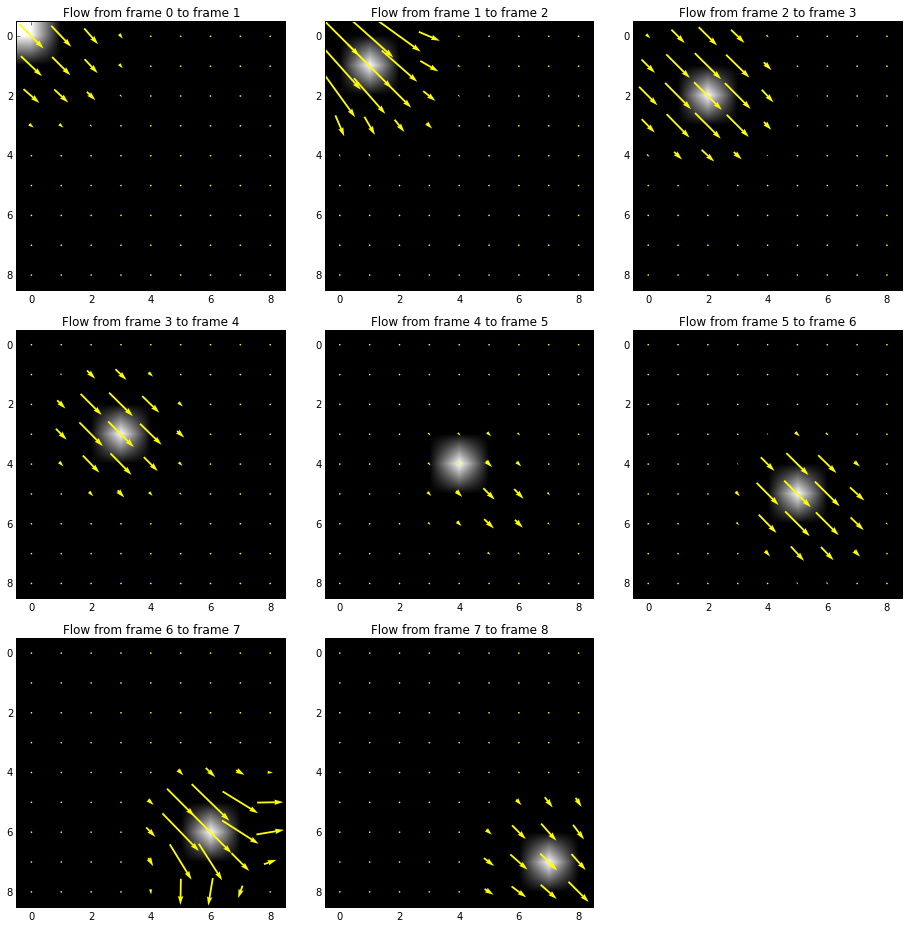

In [11]:
fy1, fx1 = calcFlow(f)
show(f, fx1, fy1)

Now we determine the flow information for the **relative fluorescence**

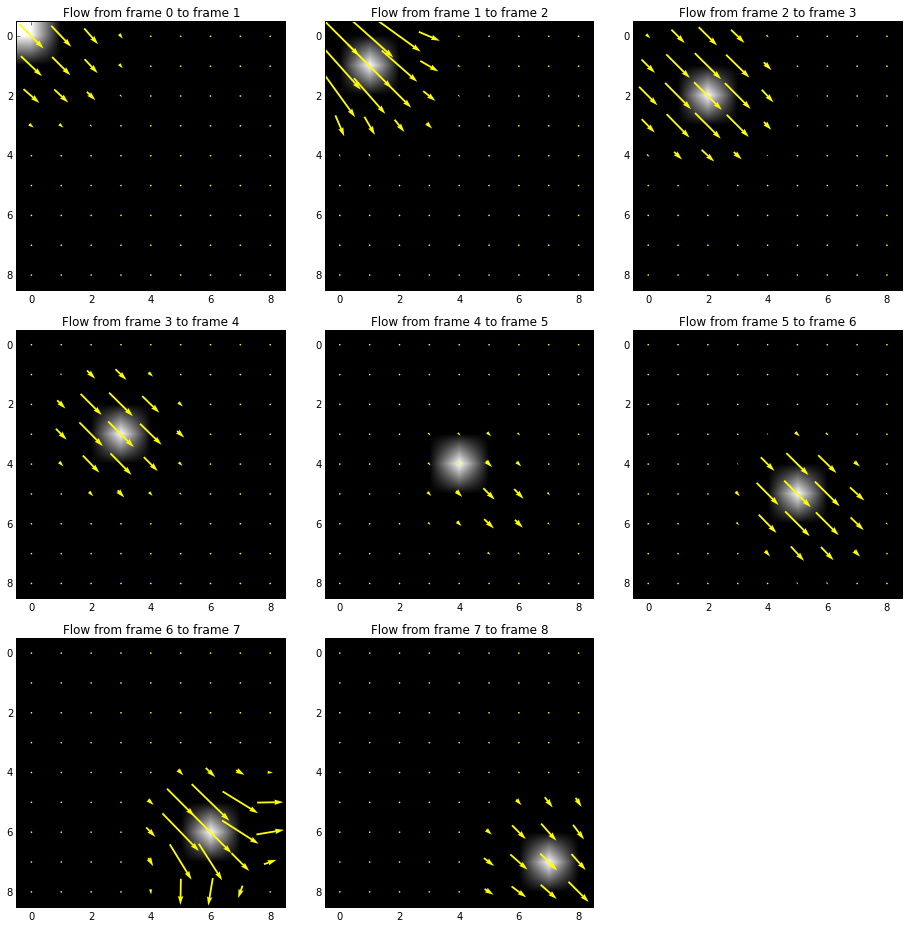

In [12]:
fy2, fx2 = calcFlow(relF)
show(relF, fx2, fy2)

Now the moment we've all be waiting for... The error analysis. I am calculating the error by first determining the L2 norm of the difference between every respective flow vector in the entire spatial and temporal dataset. This produces a 3D matrix of dimension (8,9,9). Essentially it is the point wise error between every flow vector in the dataset.

In [13]:
err1 = sqrt((fx-fx1)**2 + (fy-fy1)**2)
print "Shape = ", err1.shape
print "maximum = ", err1.max()
print "minimum = ", err1.min()

Shape =  (8, 9, 9)
maximum =  2.11579443901
minimum =  2.66626137077e-34


 Then I calculate the Frobenius norm of the matrix for each point in time. The Frobenius norm is simply the square root of the sum of squares of every component, sort of like an L2 norm for matrices. This produces a 1D array of dimension 8, where every element is a single number representing the error at each time step. 

In [14]:
frob1 = linalg.norm(err1,'fro',(1,2))
print "Shape = ", frob1.shape
print "maximum = ", frob1.max()
print "minimum = ", frob1.min()

Shape =  (8,)
maximum =  5.29822112307
minimum =  1.69656055326


Finally, I simply take the average of these errors to get one sinlge number representing the total error or *General Accuracy* of the method on **this** dataset.

In [15]:
totErr1 = average(frob1); totErr1

3.2697230870340896

Now we do the exact same thing for the relative fluorescence flow

In [16]:
err2 = sqrt((fx-fx2)**2 + (fy-fy2)**2)
print "maximum = ", err2.max()
print "minimum = ", err2.min()

maximum =  2.11579386411
minimum =  0.0


In [17]:
frob2 = linalg.norm(err2,'fro',(1,2))
print "maximum = ", frob2.max()
print "minimum = ", frob2.min()

maximum =  5.29821955503
minimum =  1.69656091233


In [18]:
totErr2 = average(frob2); totErr2

3.2697226224046529

As expected having seen the data above the results are essentially identical as we can see by looking at the difference in their total errors.

In [19]:
abs(totErr1-totErr2)

4.6462943670277923e-07

---
###Test 2
Now we add in some noise... The signal amplitude is 10, so adding a noise amplitude of 3 gives us a SNR of 3.333

In [20]:
f,fy,fx = makeData(9, noise=3.0) # Generate a another test dataset with amplitude 3 random noise
f0 = percentile(f,10,0)
relF = (f-f0)/f0

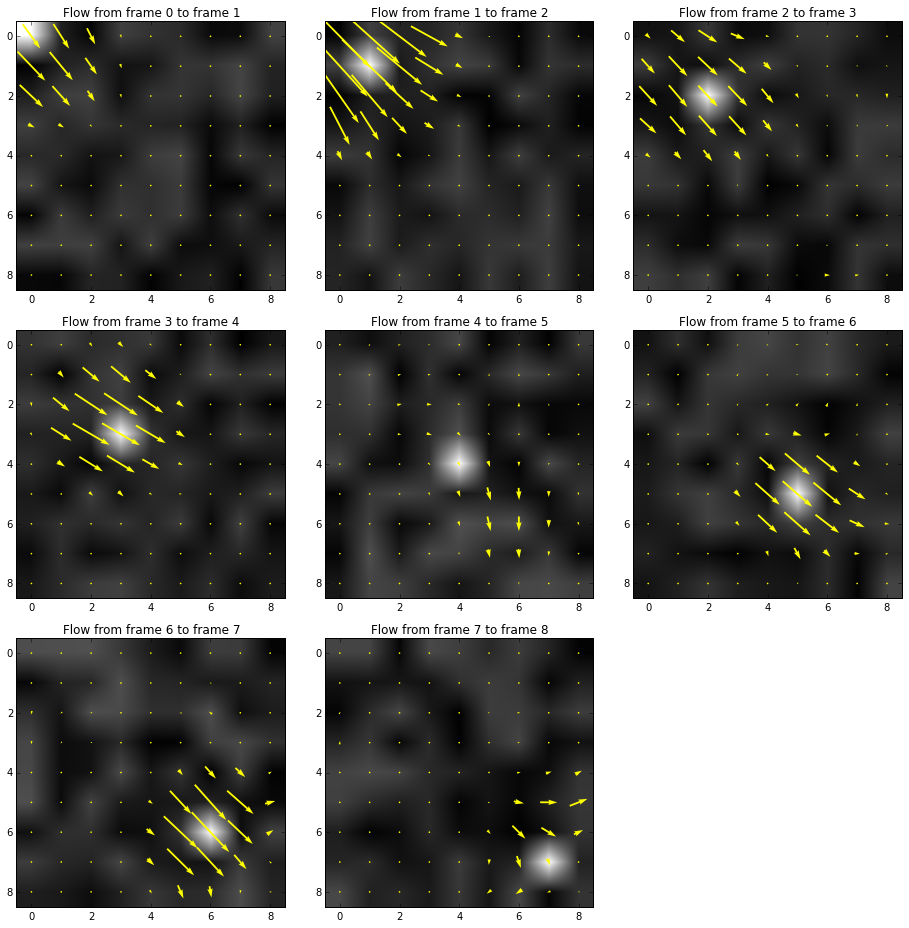

In [21]:
fy1, fx1 = calcFlow(f)
show(f, fx1, fy1)

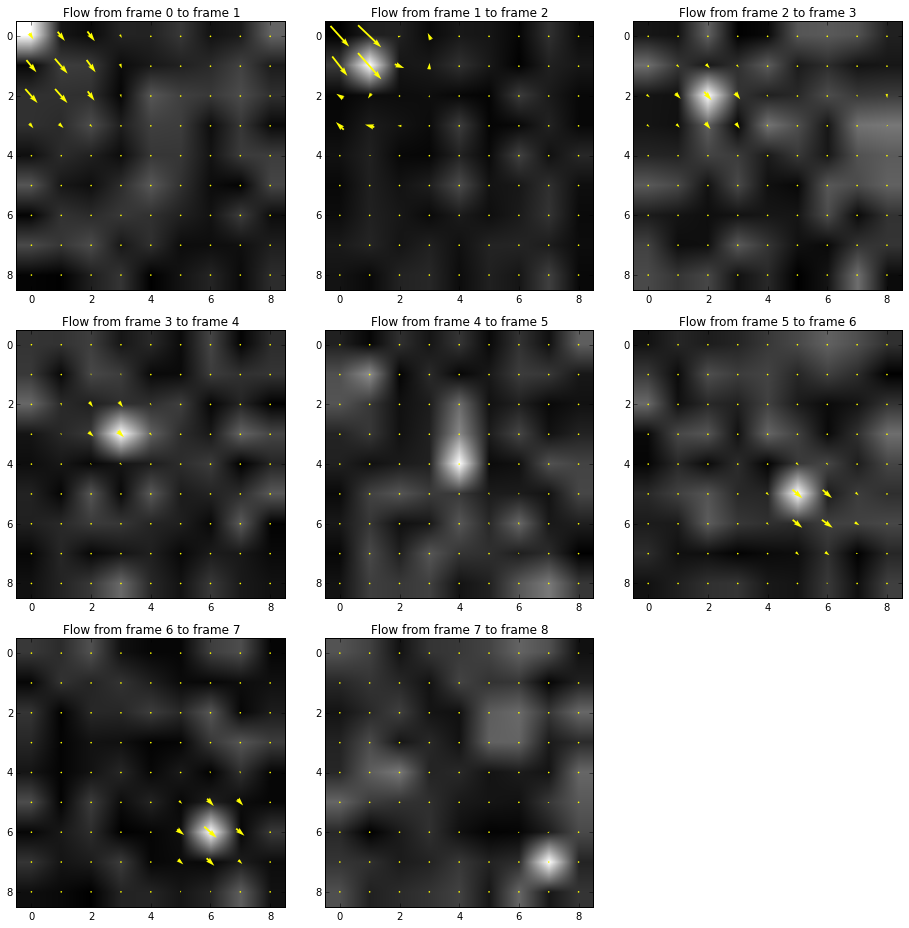

In [22]:
fy2, fx2 = calcFlow(relF)
show(relF, fx2, fy2)

In [23]:
err1 = sqrt((fx-fx1)**2 + (fy-fy1)**2)
print "maximum = ", err1.max()
print "minimum = ", err1.min()

maximum =  2.90633300283
minimum =  0.000239182318637


In [24]:
frob1 = linalg.norm(err1,'fro',(1,2))
print "maximum = ", frob1.max()
print "minimum = ", frob1.min()

maximum =  7.22203995706
minimum =  1.8065229615


In [25]:
totErr1 = average(frob1); totErr1

3.4619440236792185

In [26]:
err2 = sqrt((fx-fx2)**2 + (fy-fy2)**2)
print "maximum = ", err2.max()
print "minimum = ", err2.min()

maximum =  1.43620510568
minimum =  0.000264188258739


In [27]:
frob2 = linalg.norm(err2,'fro',(1,2))
print "maximum = ", frob2.max()
print "minimum = ", frob2.min()

maximum =  1.93917422134
minimum =  1.19791003583


In [28]:
totErr2 = average(frob2); totErr2

1.4519723426203495

In [29]:
totErr1 = average(linalg.norm(err1,'fro',(1,2)))
print "Error in Determining Flow from Regular Data = ", totErr1

Error in Determining Flow from Regular Data =  3.46194402368


In [30]:
err2 = sqrt((fx-fx2)**2 + (fy-fy2)**2)
totErr2 = average(linalg.norm(err2,'fro',(1,2)))
print "Error in Determining Flow from Relative Data = ", totErr2

Error in Determining Flow from Relative Data =  1.45197234262


In [32]:
totErr1/totErr2

2.3843043851865029

So we see in **this case** the that the relative fluorescence flow is more than twice as accurate. However, I can't be certain whether that is because the relative fluorescence flow is actually more accurate or if it is a result of their being fewer vectors in the relative fluorescence calculations. To ameliorate this I will need to normalize the errors. It is late. I will leave that for tomorrow.